In [2]:
import vespa
import h5py
import numpy as np
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants 

from scipy.stats import gaussian_kde
import scipy.special as ss

import emcee
import corner

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from EBLSST import BreivikGalaxy, EclipsingBinary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get the field centers and number of observations from OpSim

In [ ]:
#https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335
#http://ops2.lsst.org/docs/current/architecture.html
db = sqlite3.connect('/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db')
cursor = db.cursor()
cursor.execute("SELECT fieldid, fieldra, fielddec, fieldFov FROM field")
#cursor.execute("SELECT fielddec FROM field")
fieldCursor = np.array(cursor.fetchall()) 

cursor.execute("SELECT fieldid, expDate, filter FROM summary")
summaryCursor = np.array(cursor.fetchall()) 
FieldID = summaryCursor[:,0].astype('int')
date = summaryCursor[:,1].astype('float')

fID = np.array([])
RA = np.array([])
Dec = np.array([])
nobs = np.array([])
for x in fieldCursor:
    inS = np.where(FieldID == int(x[0]))[0]
    nobs = np.append(nobs, len(inS))
    fID = np.append(fID, x[0])
    RA = np.append(RA, x[1])
    Dec = np.append(Dec, x[2])
    
    print(x[0], x[1], x[2],len(inS))


In [ ]:
coords = SkyCoord(RA, Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree

f,ax = plt.subplots()
ax.hist(nobs,bins = 100, range=(0,5000))
ax.set_yscale('log', nonposy='clip')

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(nobs > 0)
ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$l$",fontsize=16)
ax.set_ylabel(r"$b$",fontsize=16)
ax.scatter(lGal[xx]*np.pi/180.,bGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)


### Get the TRILEGAL simulation at each OpSim field

*Just look at the first one for a test*

In [ ]:
#this area is a bit odd because we're on a sphere... 
area = 10.
maglim = 24
sigma_AV = 0.1 #default
binaries = False
filterset = 'lsst' #kepler_2mass

for r,d,f in zip(RA,Dec,fID):
    print(r,d,f)
    filename = 'grid/trilegal.grid.id'+str(f)
    x = vespa.stars.trilegal.get_trilegal(filename, r, d, galactic=False, \
                                  filterset=filterset, area=area, maglim=maglim, binaries=binaries, \
                                  trilegal_version='1.6', sigma_AV=sigma_AV, convert_h5=True)
    
    break

In [ ]:
print(x)

## Read in the TRILEGAL model to test

In [3]:
filename = 'grid/trilegal.grid.id1.0.h5'
df = pd.read_hdf(filename)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec
logDist = np.log10( 10.**(df['m-M0'].values/5.) *10. / 1000.) #log(d [kpc])
df['logDist'] = logDist

print(df)

data = np.vstack((df['logL'].values, df['logTe'].values, df['logg'].values, df['logDist'].values, \
                  df['Av'].values, df['[M/H]'].values))
TRILEGAL_KDE = gaussian_kde(data)


        Gc  logAge  [M/H]     m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    6.65   0.27   0.51311 -1.374  3.592  4.837   7.2  0.347    0.0   
1        1    6.71  -0.19   0.13318 -1.740  3.509  4.285   8.0  0.458    0.0   
2        1    6.71  -0.09   0.74550 -0.736  3.671  4.676   8.2  0.371    0.0   
3        1    6.87  -0.07   1.62066  0.870  3.896  4.307   9.7  0.568    0.0   
4        1    6.87   0.07   0.74828 -0.767  3.661  4.668   8.8  0.431    0.0   
5        1    6.87   0.27   1.31862  0.403  3.806  4.326  12.8  0.432    0.0   
6        1    7.07   0.23   0.11043 -1.914  3.482  4.269   4.4  0.112    0.0   
7        1    7.15  -0.17   0.78918 -0.596  3.693  4.650   7.6  0.372    0.0   
8        1    7.15  -0.09   0.80570 -0.582  3.693  4.642  10.3  0.457    0.0   
9        1    7.17   0.13  14.01946  4.484  4.395  3.626   9.3  0.483    0.0   
10       1    7.21   0.17   0.22026 -2.181  3.536  5.052   7.1  0.346    0.0   
11       1    7.25   0.01   0.35666 -1.7

*Check some plots*

103604


Text(0.5,0,'[M/H]')

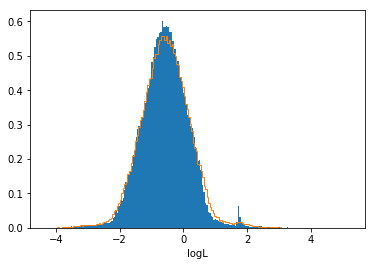

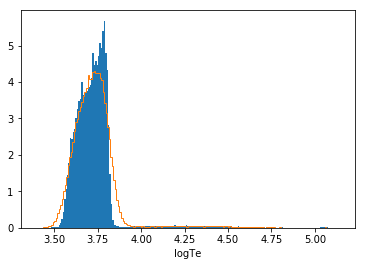

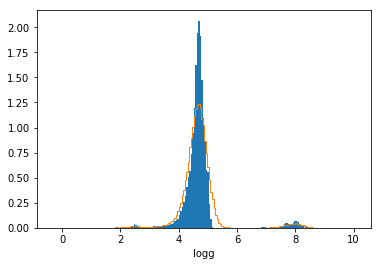

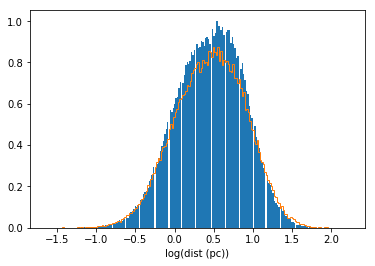

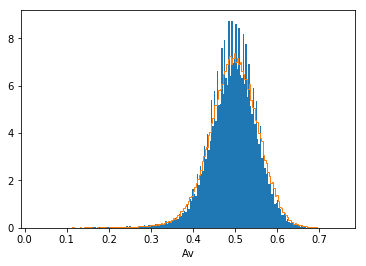

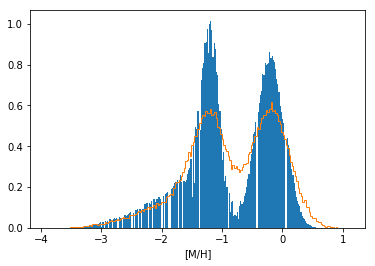

In [4]:
print(len(df))
nbins = 200

sample = TRILEGAL_KDE.resample(size=int(1e5))
    


# f,ax = plt.subplots()
# n, bins, patches = ax.hist(df['Av'].values, bins=nbins, density=True)
# ax.set_xlabel('Av')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logL'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logL')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logTe'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logTe')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logg'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[2,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logg')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logDist'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[3,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('log(dist (kpc))')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['Av'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[4,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('Av')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['[M/H]'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[5,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('[M/H]')

### Now draw some binaries from Katie Breivik's model

In [5]:
g = BreivikGalaxy()

#define the correct paths to the input files and db
g.GalaxyFile ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/Breivik/dat_ThinDisk_12_0_12_0.h5' #for Katie's model
g.GalaxyFileLogPrefix ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/Breivik/fixedPopLogCm_'

g.getKernel()

The number of binaries in the Gx for: 0012 is: 22919080853
both bright stars and eccentric


*set up a dict with min, max values to transfor the data in the likelihood below*

In [6]:
def paramMinMax(dat):
    datMin = min(dat)-0.0001
    datMax = max(dat)+0.0001

    return [datMin, datMax]

toTransform = ['m1', 'm2', 'logp','ecc','logr1','logr2','logL1','logL2']
datMinMax = dict()

for x in toTransform:
    datMinMax[x] = paramMinMax(g.fixedPop[x])

print(datMinMax)

{'m1': [0.0847977267742157, 9.45289598236084], 'm2': [0.07997638156414032, 8.023753984069824], 'logp': [-3.9578333927154543, 6.260593755340576], 'ecc': [-0.0001, 0.9878179265022278], 'logr1': [-2.9347997737884524, 2.3233359886169436], 'logr2': [-2.133080823516846, 2.329724891281128], 'logL1': [-5.506008489227295, 3.9502960277557375], 'logL2': [-5.283521516418457, 3.7637818885803225]}


*This is how to draw stars from Katie's model*

*Note: here the rad and lum values are NOT in the log*

In [7]:
nSample = 1
BreivikBin = g.GxSample(nSample)
EB = EclipsingBinary()
BreivikBin['Teff1'] = EB.getTeff(10.**BreivikBin['logL1'].values[0], 10.**BreivikBin['logr1'].values[0])
BreivikBin['Teff2'] = EB.getTeff(10.**BreivikBin['logL1'].values[0], 10.**BreivikBin['logr2'].values[0])
print(BreivikBin)


         m1        m2      logp       ecc     logr1     logr2     logL1  \
0  0.786031  0.705167  3.299704  0.410298  0.019733  0.834584  0.000017   

      logL2          xGX          yGX        zGX  dist_kpc       inc  \
0  0.086458  2532.362649  4060.491208 -613.55901  6.840351  1.520745   

      OMEGA     omega        Teff1        Teff2  
0  4.347902  2.633896  5651.160203  2211.628331  


### Use emcee to sample Breivik's model using the logL and logT distributions from TRILEGAL

*For our LSST model, I need the following from Katie:*

**m1, m2, r1, r2, ecc, porb**

*I also need to following, but these are random anyway:*

**omega, inc**

inc = np.arccos(2.*np.random.uniform(0,1.0,len(m1)) - 1.)

omega = np.random.uniform(0,2*math.pi,len(m1))

In [69]:
# compute the log likelihood
def lnlike(theta, logm1, logr1, logL1, pT):
    logm2, logr2, logL2, ecc, logp = theta
    
    def paramTransform(key, val):
        datMin = datMinMax[key][0]
        datMax = datMinMax[key][1]
                
        return (val - datMin)/(datMax-datMin)
    
#NOTE: this is confusing, but in g.fixedPop rad and lum are already in the log! 
#And here I have already transformed porb to logP
    m1Trans = ss.logit(paramTransform('m1', 10.**logm1))
    m2Trans = ss.logit(paramTransform('m2', 10.**logm2))
    r1Trans = ss.logit(paramTransform('logr1', logr1))
    r2Trans = ss.logit(paramTransform('logr2', logr2))
    L1Trans = ss.logit(paramTransform('logL1', logL1))
    L2Trans = ss.logit(paramTransform('logL2', logL2))
    pTrans = ss.logit(paramTransform('logp', logp))
    eccTrans = np.clip(ecc, 1e-4, 0.999)
        
    pB = g.sampleKernel( (m1Trans, m2Trans, pTrans, eccTrans, r1Trans, r2Trans, L1Trans, L2Trans) )
    lk = pB# * pT
    
    if (lk <= 0):
        return -np.inf
    
    return np.log(lk).squeeze()

# compute the log prior
def lnprior(theta):
    #some reasonable limits to place, so that Breivik's KDE can be sampled properly
    logm2, logr2, logL2, ecc, logp = theta
    if ( (-2 < logm2 < 2) and (-3 < logr2 < 3) and (-5 < logL2 < 5) and (0 < ecc < 1) and (-3 < logp < 10)):
        return 0.0
    return -np.inf

# compute the log of the likelihood multiplied by the prior
def lnprob(theta):
    lnp = lnprior(theta)
    
    #get the primary star from the TRILEGAL model
    sample = TRILEGAL_KDE.resample(size=1)
    logL1 = sample[0,0]
    logT1 = sample[1,0]
    logg1 = sample[2,0]
    logD = sample[3,0]
    Av = sample[4,0]
    MH = sample[5,0]
    pT = TRILEGAL_KDE( (logL1, logT1, logg1, logD, Av, MH) )

    logr1 = 2.*(0.25*logL1 - logT1 + 3.762) #taken from my N-body notes to get logT <-- from Jarrod Hurley
    
    #np.log10(constants.G.to(u.cm**3. / u.g / u.s**2.).value) = -7.175608591905032
    #print(np.log10((1.*u.solMass).to(u.g).value)) = 33.29852022592346
    logm1 = logg1 + 7.175608591905032 + 2.*(logr1 + 10.84242200335765) - 33.29852022592346

    lnl = lnlike(theta, logm1, logr1, logL1, pT)
    
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf, np.array([0., 0., 0., 0., 0., 0.])

    #returning the TRILEGAL parameters as "blobs" so that I can1 use them later
    return lnp + lnl, np.array([Av, MH, logD, logm1, logr1, logL1])

In [70]:
#some function to make plots (will re-use them later)
#to plot the chains
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

In [ ]:
nwalkers = 100
ncores = 4
nsamples = 2000

paramsNames = ['m2', 'logr2', 'logL2', 'ecc', 'logp']
outNames = ['logm2', 'logr2', 'logL2', 'ecc', 'logp']
reNames = {}
for x,y in zip(paramsNames, outNames):
    reNames[x] = y

BreivikBin = g.GxSample(int(nwalkers))

#take the log of m2 and rename the columns accordingly
walkers = pd.concat( [ BreivikBin[paramsNames[0]].apply(np.log10), BreivikBin[paramsNames[1:]] ], axis=1)
walkers.rename(columns = reNames, inplace=True)

sampler = emcee.EnsembleSampler(nwalkers, len(outNames), lnprob, threads = ncores)

foo = sampler.run_mcmc(walkers.values, nsamples)

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


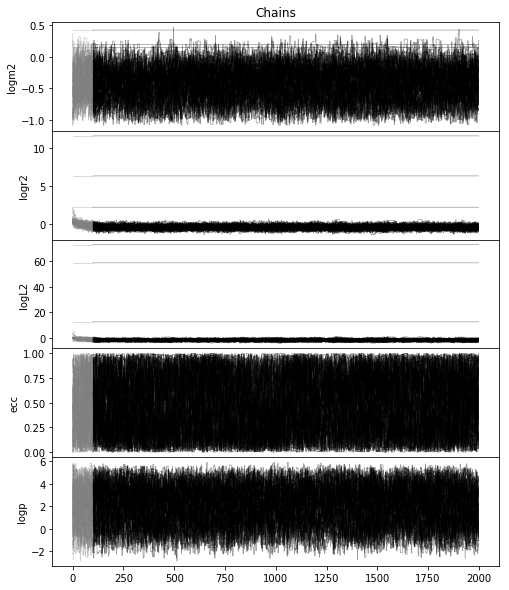

In [11]:
nburn = 100
axC = plotChains(sampler, nburn, outNames)

In [68]:
samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
extras = np.array(sampler.blobs[nburn:][:][:]).reshape((-1, samples.shape[0])).T
print(extras.shape)
print(samples.shape)
result = np.hstack((extras, samples))

print(result.shape)

outNames = ['Av', '[M/H]', 'logD','logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
f = corner.corner(result, labels = outNames, quantiles = [0.16, 0.5, 0.84])


(190000, 6)
(190000, 5)
[0.436029091258703 -1.1069047750196925 -0.12590619926044866
 0.5213288529018644 -0.866969911094241 -0.10617452847007058]
(190000, 11)


TypeError: '<=' not supported between instances of 'float' and 'NoneType'

### Compare to Breivik's model

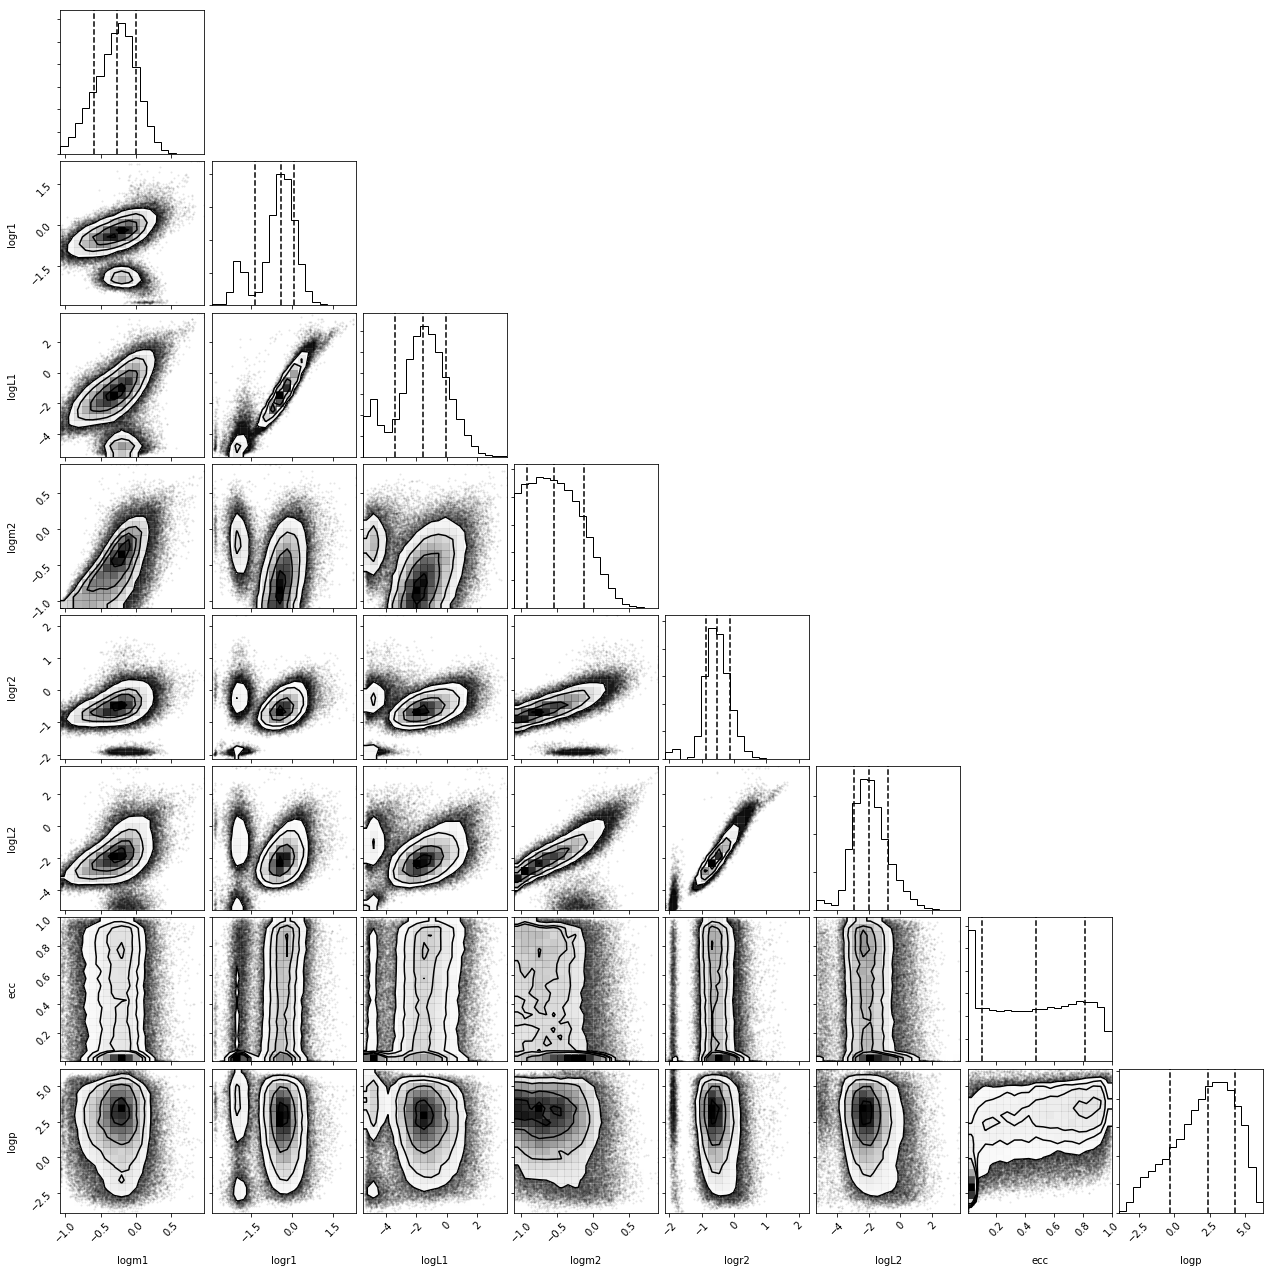

In [33]:
paramsNames = ['m1', 'logr1', 'logL1', 'm2', 'logr2', 'logL2', 'ecc', 'logp']
outNames = ['logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
reNames = {}
for x,y in zip(paramsNames, outNames):
    reNames[x] = y

BreivikBin = g.GxSample(int(1e5))

check = pd.concat( [ BreivikBin[paramsNames[0]].apply(np.log10), 
                    BreivikBin[paramsNames[1:2]], 
                    BreivikBin[paramsNames[3]].apply(np.log10), 
                    BreivikBin[paramsNames[4:]], 
                   ], axis=1)
check.rename(columns = reNames, inplace=True)

#print(check)
      
f = corner.corner(check.values, labels = outNames, quantiles = [0.16, 0.5, 0.84])


### Construct lines as if they came directly from Katie's code and create light curve

*Draw a N random binaries from the emcee sampler*

*And put it in the format that is expected by our code:*

**m1, m2, logp, ecc, rad1, rad2, Lum1, Lum2, xGX, yGX, zGX, dist_kpc, inc, OMEGA, omega**


### I do need to check if m1 = 0 (then the sampler returned infs)

In [ ]:
Nsample = 5
indices = np.random.randint(0, high=len(result), size=Nsample)
s = result[indices].T
#outNames = ['Av', '[M/H]', 'logD', logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
use = np.where(s[2] > 0)
Nsample = len(use)
print(Nsample, use)

Av = s[0][use]
MH = s[1][use]
d = 10.**s[2][use]
m1 = 10.**s[3][use]
r1 = 10.**s[4][use]
L1 = 10.**s[5][use]
m2 = 10.**s[6][use]
r2 = 10.**s[7][use]
L2 = 10.**s[8][use]
ecc = s[9][use]
logp = s[10][use]
inc = np.arccos(2.*np.random.uniform(0,1.0,Nsample) - 1.)
omega = np.random.uniform(0,2*math.pi,Nsample)
OMEGA = np.random.uniform(0,2*math.pi,Nsample)
x = np.zeros(Nsample)

#we don't need position, but we do need distance
#[m1, m2, logp, ecc, r1, r2, L1, L2, x,y,z, dist, inc, OMEGA, omega, Av, MH]
#binDat = np.vstack((m1, m2, logp, ecc, rad1, rad2, Lum1, Lum2, xGX, yGX, zGX, dist_kpc, inc, OMEGA, omega)).T		

output = np.hstack( (m1, m2, logp, ecc, r1, r2, L1, L2, x, x, x, x, inc, OMEGA, omega, Av, MH) )
print(output)

i = 0
EB = worker.getEB(line, i)

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

f,ax = plt.subplots(6,1, figsize=(6,8))
for i,f in enumerate(worker.filters):
    EB.observe(f)

    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMag[f],'.', color='red')
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMagObs[f],'.', alpha=0.3, color='blue')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)

### Some checks for the numbers used in the likelihood

In [ ]:
print(constants.G.to(u.cm**3. / u.g / u.s**2.))
print(np.log10(constants.G.to(u.cm**3. / u.g / u.s**2.).value))
print(np.log10((1.*u.solMass).to(u.g).value))
print(np.log10((1.*u.solRad).to(u.cm).value))
print( np.log10((constants.G*1*u.solMass/(1.*u.solRad)**2.).decompose().to(u.cm/u.s**2).value))

logm = 4.44 + 7.175608591905032 + 2.*(0. + 10.84242200335765) - 33.29852022592346
print("logm = ",logm)
print("mass = ",10**logm)